<a href="https://colab.research.google.com/github/nasirhemed/handson-ml/blob/master/FMNIST_GAN_fillmein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# * Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

# enable eager execution
tf.enable_eager_execution()

In [2]:
# check that TF can detect GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2248677517566287591, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3923292543993509288
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 313509946796748407
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17584504360058701906
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# 1 Fashion MNIST Dataset

Load train/test datasets from API

Similar to MNIST Digit dataset. Results can get pretty fast


In [0]:
# download the fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist # Under keras default dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # By default we get train images and train labels

28X28 images 


In [5]:
# examine dataset format
print("train images: type: {}; shape: {}".format(type(train_images), train_images.shape))
print("test images: type:  {}; shape: {}".format(type(test_images), test_images.shape))

# examine class frequency
print("train labels: {}".format([(a,b) for a, b in zip(np.unique(train_labels), np.bincount(train_labels))]))
print("test labels:  {}".format([(a,b) for a, b in zip(np.unique(test_labels), np.bincount(test_labels))]))

train images: type: <class 'numpy.ndarray'>; shape: (60000, 28, 28)
test images: type:  <class 'numpy.ndarray'>; shape: (10000, 28, 28)
train labels: [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]
test labels:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


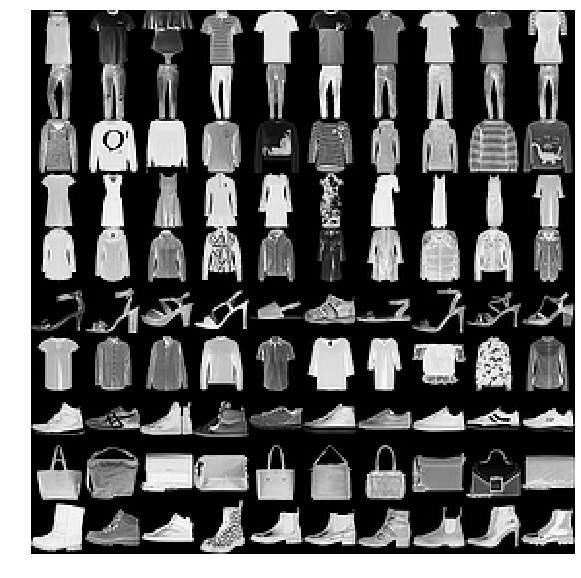

In [6]:
# visualize some of the images by randomly sampling a few images from each class
img_samples = []
"""
Go through each of the classes
Figure out which ones are classes
Randomly choose samples 

NOTE: You can convert np to tf arrays easlily
"""
for cls in list(np.unique(train_labels)): 
    indices = np.where(train_labels==cls)[0]    
    samples = np.random.choice(a=indices, size=10, replace=False)
    img_samples.append(train_images[samples,:,:])
img_samples = tf.constant(np.concatenate(img_samples)) # Concatenate list
img_samples = tf.expand_dims(img_samples, 3)
# We have 3D array that has dimension height, width and something

# generate a 10 x 10 image grid
img_grid = tf.contrib.gan.eval.image_grid(
                input_tensor=img_samples,
                grid_shape=(10,10),
                image_shape=(28,28),
                num_channels=1
            )
# Create image grid

# plot the image grid
plt.figure(figsize=(10,10))
plt.imshow(img_grid[0,:,:,0], cmap='gray')
plt.axis('off')
plt.show()

# 2 GAN Models

Create sequential model and the way you do it is by definining sequence
Import sequential and import all the building layers

In [0]:
# Import keras modules that we will be using to construct our models
from tensorflow.keras.models import Sequential # Sequential model 
from tensorflow.keras.layers import (
    Dense, ReLU, Activation, Flatten, Conv2D, LeakyReLU, 
    Conv2DTranspose, Input, Reshape, BatchNormalization
)

In [8]:
# create an image batch for testing model functionalities
images = train_images[:64,:,:]/128. - 1.
images = tf.constant(images, dtype=tf.float32)
images = tf.expand_dims(images, 3)
images.shape

TensorShape([Dimension(64), Dimension(28), Dimension(28), Dimension(1)])

In [0]:
# input image shape information
H, W, C =28, 28, 1# Changed from 1 to 3
LATENT_DIM=16

# alpha param for leaky ReLu
ALPHA = 0.2

### Discriminator

Note: for a really good introduction to 2D-convolution operation for image processing, please check out: https://www.youtube.com/watch?time_continue=422&v=z9wiDg0w-Dc (time 2:29)


In [0]:
def build_discriminator():
    # Essentially, it is going to be 3 convolutional layers with 
    # Leaky ReLu as the loss function
    return Sequential([
        # reshape input layer
        Reshape((H, W, C), input_shape=(H, W)), # We are putting in actual images in the reshape
        
        # <TODO>
        # 1st conv2D layer + leaky relu
        # (filters=32, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=32, kernel_size=5, strides=2, padding='same'), # Filters represents the number of  convolutions
        LeakyReLU(ALPHA),
        
        # 2nd conv2D layer
        # (filters=64, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # 3rd conv2D layer
        # (filters=128, kernel_size=5, strides=2, padding='same')
        Conv2D(filters=128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # Flatten conv2D output
        Flatten(),
        # Output layer (units=1)
        Dense(units=1),
        # Sigmoid activation 
        Activation('tanh') # tanh used due to hinge loss 
    ])
      
      
def compute_d_loss(d_logits_real, d_logits_fake):
    """
    loss computation for the discriminator net
    """
    # Hinge loss
    real_loss = tf.reduce_mean(tf.nn.relu(1. - d_logits_real)) # loss function for real values
    fake_loss = tf.reduce_mean(tf.nn.relu(1. + d_logits_fake)) # loss function for fake values

    return real_loss + fake_loss

In [17]:
# build discriminator model
d_net = build_discriminator()
print(d_net.summary())

# unit test by passing an images batch to the discriminator model
test = d_net(images)
print('\ndiscriminator loss: ', compute_d_loss(test, test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

### Generator

Note: for a great explanation on batch normalization (from everyone's favorite Andrew Ng): https://www.youtube.com/watch?v=nUUqwaxLnWs

In [0]:
def build_generator():
    return Sequential([

        # fully connected layer on latent vector + batch norm + leaky relu
        Dense(units=(H/4)*(W/4)*64, use_bias=False, input_shape=[LATENT_DIM]),
        BatchNormalization(),
        LeakyReLU(ALPHA),

        # <TODO>
        # reshape 1-D tensor into 3-D tensor
        Reshape(((H/4), (W/4), 64)),
        # 1st conv2d transpose operation + batch norm + leaky relu
        # filters=64, kernel_size=5, strides=1, padding='same', use_bias=False
        Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', use_bias=False), #Conv2D squeeze and expand dimension
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # Transpose expands and squeezes
        # 2nd conv2d transpose operation + batch norm + leaky relu
        # filters=32, kernel_size=5, strides=2, padding='same', use_bias=False
        Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # 3rd deconv operation
        # filters=C, kernel_size=5, strides=2, padding='same', use_bias=False
        Conv2DTranspose(filters=C, kernel_size=5, strides=2, padding='same', use_bias=False),                
        # output operation
        Activation('tanh'),
    ])

      
def compute_g_loss(d_logits_fake):
    return - tf.reduce_mean(d_logits_fake)

In [29]:
# build generator network
g_net = build_generator()
print(g_net.summary())

# unit test by feeding in a batch of randomly generated latent vectors 
# into generator network
z_test = tf.random_normal(shape=(64, LATENT_DIM), dtype='float32')
test = g_net(z_test)
test_logit = d_net.call(test)
print('\ndiscriminator loss on generated images: ', compute_g_loss(test_logit))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3136)              50176     
_________________________________________________________________
batch_normalization_9 (Batch (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 3136)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 64)          102400    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

# 3 Model Training

### Setup

In [0]:
# training configuration information
SAMPLE_PER_N_STEPS=200

# training batch size & epoch
BUFFER_SIZE=1000
EPOCHS = 10 # Number of times you repeat through the dataset
BATCH_SIZE = 128

### Optimizers

In [0]:
# learning rates
G_LR = 0.0001
D_LR = 0.0004

# beta params for the Adam optimizer
BETA1 = 0.0 # Optimizer for discriminator model
BETA2 = 0.999 # Optimizer for generative model

# generator optimizer
g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

# discriminator optimizer
d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

### Data Pipeline

In [0]:
# combine the train/test datasets because we won't be needing the test dataset
dataset = np.concatenate((train_images, test_images))

# convert dataset to 4-D tensor object format (batch, height, width, channel)
dataset = tf.constant(dataset, dtype=tf.float32)
dataset = tf.expand_dims(dataset, 3)

# create a tf.dataset object that will act as our input pipeline to feed data
# to our models during training
dataset = tf.data.Dataset.from_tensor_slices(dataset) # Key for feeding in numpy array. Convert tensor data to dataset object

# we will pre-program how the tf.dataset object will be feeding in data batches # You can use dataset.map method
dataset = dataset.map(lambda x: (x / 128.) - 1., num_parallel_calls=4)\
                 .shuffle(BUFFER_SIZE)\
                 .repeat(EPOCHS)\
                 .batch(BATCH_SIZE)

In [35]:
dataset

<BatchDataset shapes: (?, 28, 28, 1), types: tf.float32>

### Training

training step 100: discriminator loss 0.7053691148757935; generator loss 0.4762636423110962
training step 200: discriminator loss 1.1655726432800293; generator loss 0.5047722458839417


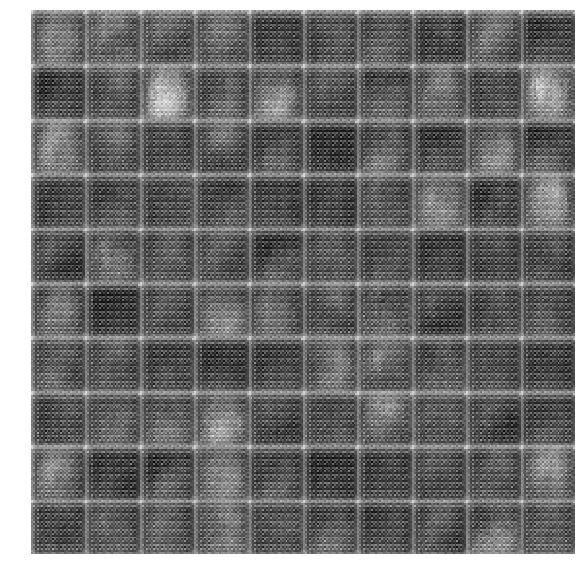

training step 300: discriminator loss 1.3815981149673462; generator loss -0.12465208768844604
training step 400: discriminator loss 1.419127106666565; generator loss 0.9707216024398804


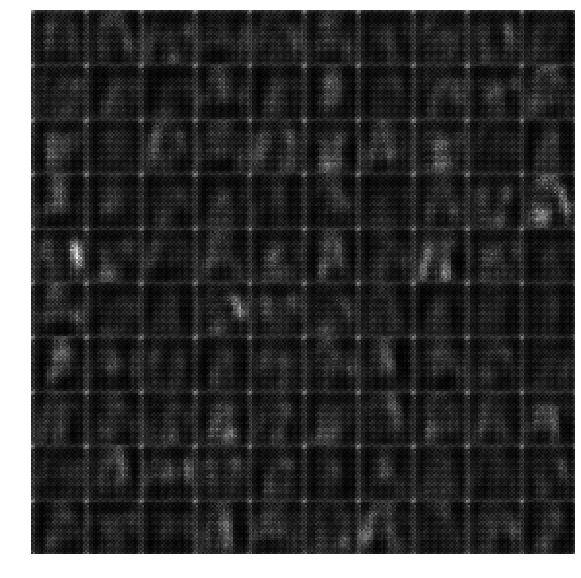

training step 500: discriminator loss 1.1591154336929321; generator loss 0.8592149019241333
training step 600: discriminator loss 1.2377160787582397; generator loss 0.6774295568466187


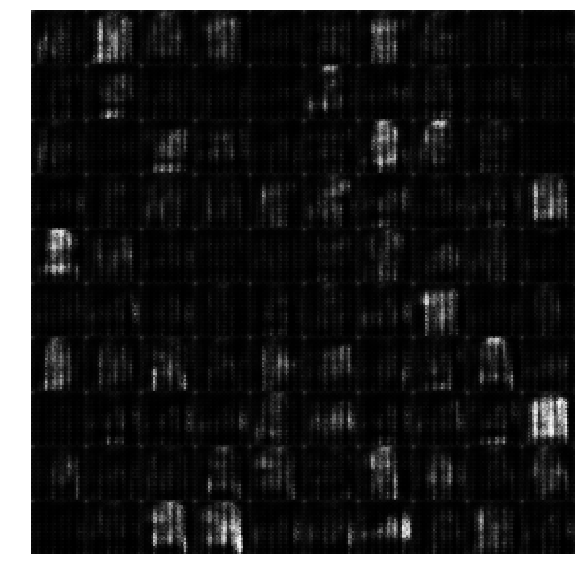

training step 700: discriminator loss 1.567091941833496; generator loss 0.9603650569915771
training step 800: discriminator loss 1.3663991689682007; generator loss 0.8148220777511597


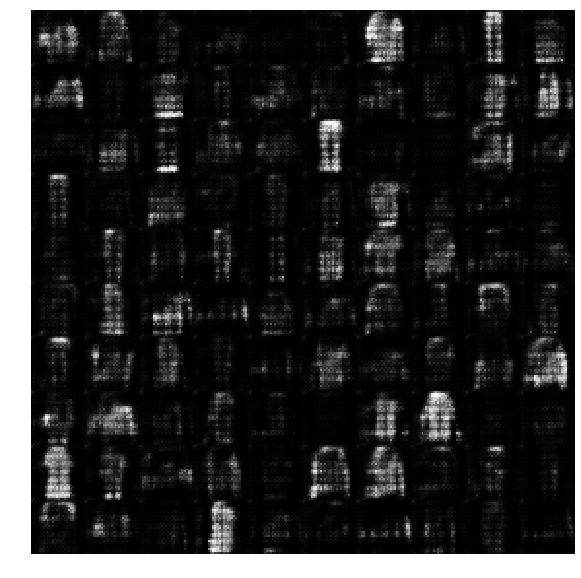

training step 900: discriminator loss 0.9765224456787109; generator loss 0.8220186829566956
training step 1000: discriminator loss 1.275963306427002; generator loss 0.9263261556625366


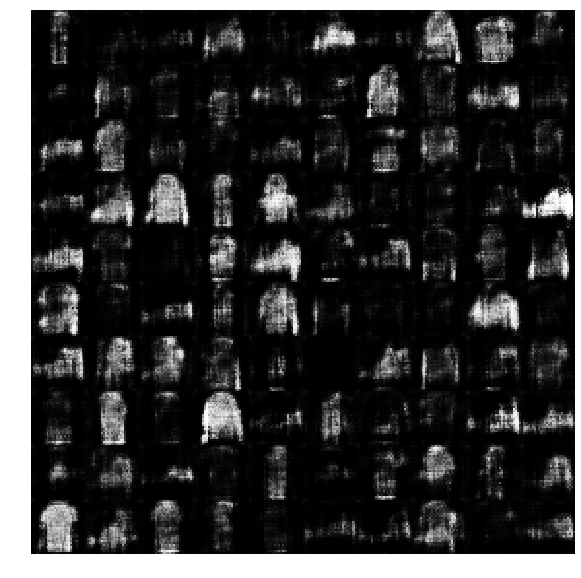

training step 1100: discriminator loss 1.2389415502548218; generator loss 0.06305313110351562
training step 1200: discriminator loss 1.1093653440475464; generator loss 0.8741869330406189


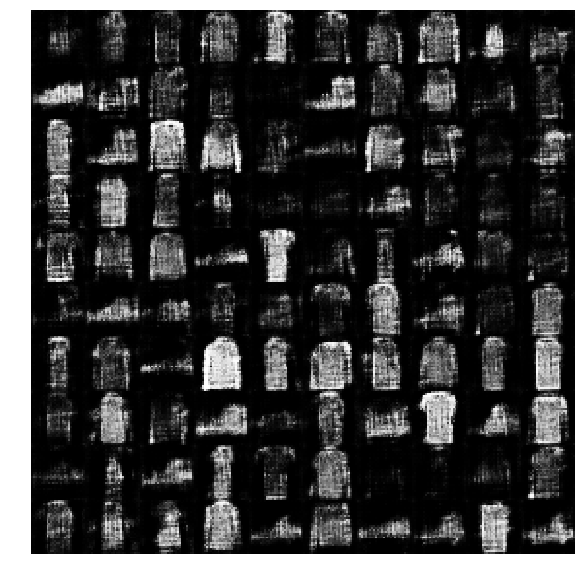

training step 1300: discriminator loss 1.2666480541229248; generator loss 0.04648180305957794
training step 1400: discriminator loss 1.1171189546585083; generator loss 0.8745230436325073


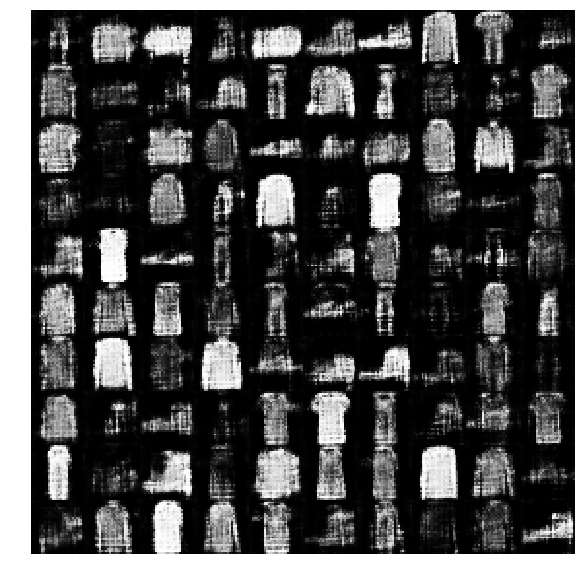

training step 1500: discriminator loss 1.3013696670532227; generator loss -0.026045899838209152
training step 1600: discriminator loss 1.43044912815094; generator loss 0.9331451058387756


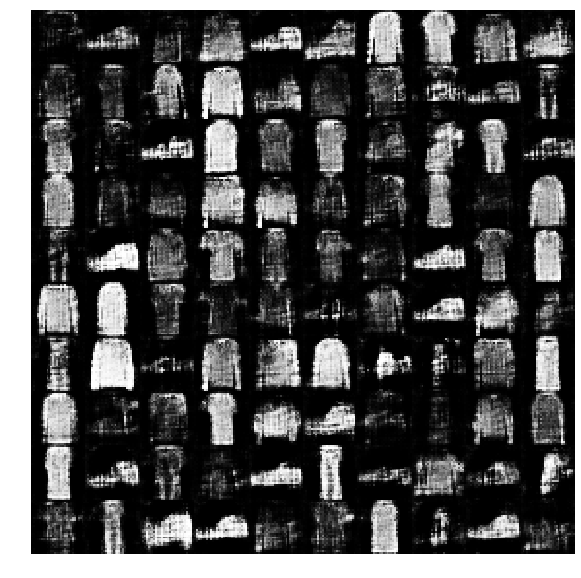

training step 1700: discriminator loss 1.2123312950134277; generator loss 0.8218342065811157
training step 1800: discriminator loss 1.5065051317214966; generator loss 0.8998033404350281


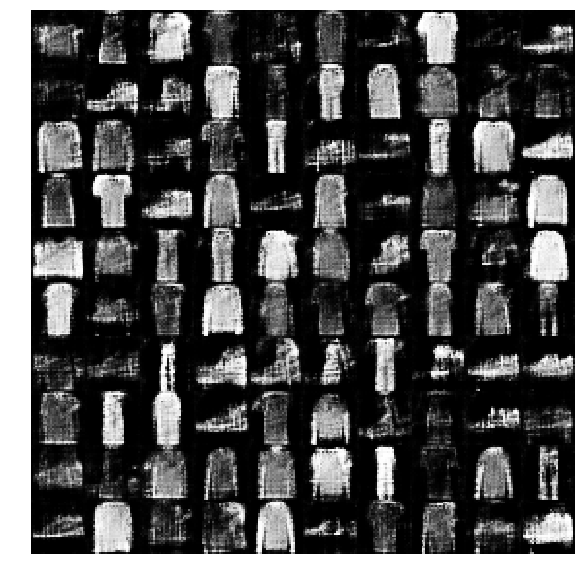

training step 1900: discriminator loss 1.1164273023605347; generator loss 0.4754989445209503
training step 2000: discriminator loss 1.3146308660507202; generator loss 0.8761670589447021


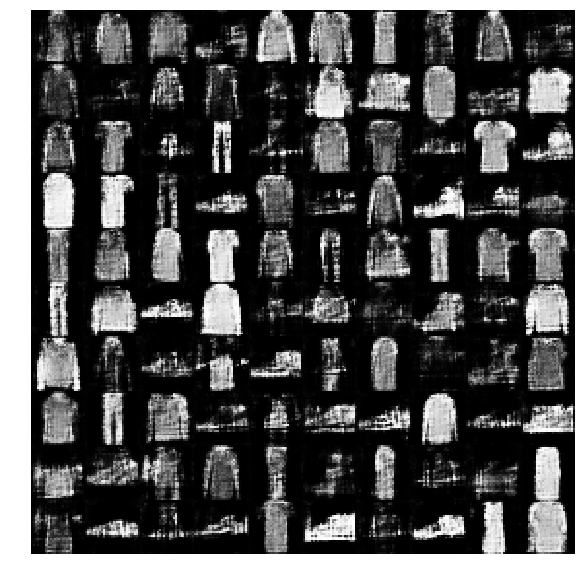

training step 2100: discriminator loss 1.327396035194397; generator loss 0.01982961595058441
training step 2200: discriminator loss 1.2221053838729858; generator loss 0.43813490867614746


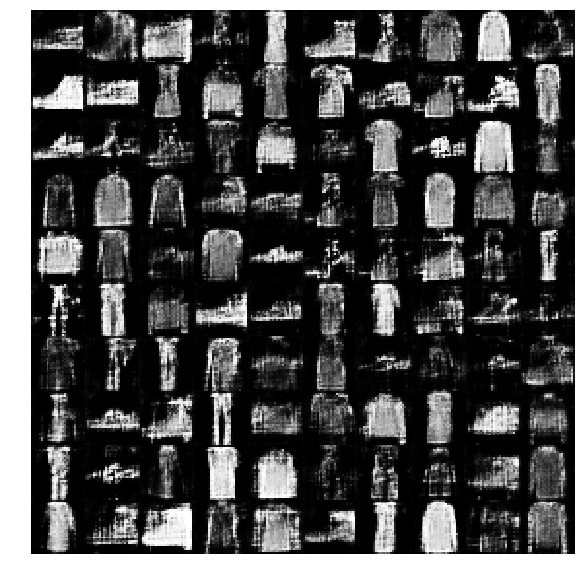

training step 2300: discriminator loss 1.3510483503341675; generator loss -0.1979079246520996
training step 2400: discriminator loss 1.4581973552703857; generator loss -0.2395745813846588


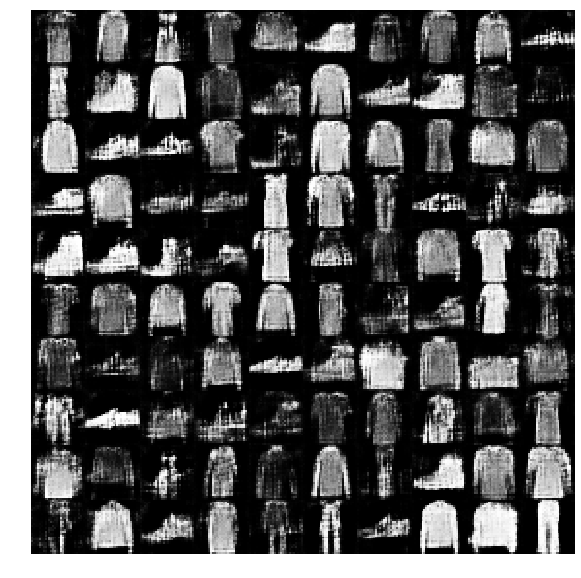

training step 2500: discriminator loss 1.3551700115203857; generator loss 0.602104663848877
training step 2600: discriminator loss 1.334174633026123; generator loss 0.11836186051368713


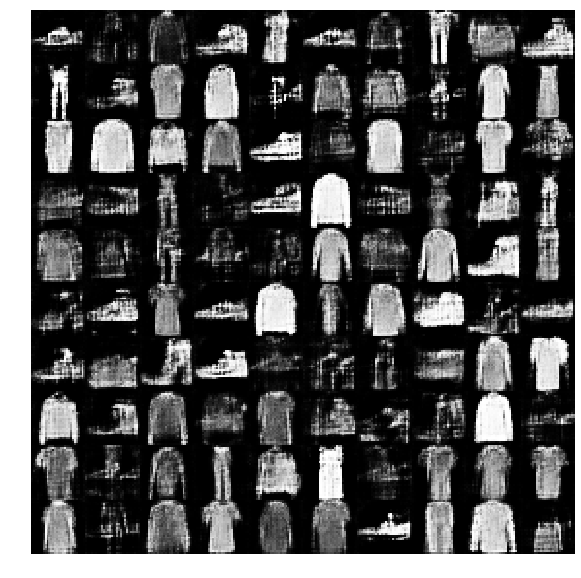

training step 2700: discriminator loss 1.3439393043518066; generator loss 0.24098756909370422
training step 2800: discriminator loss 1.5039030313491821; generator loss 0.9107056856155396


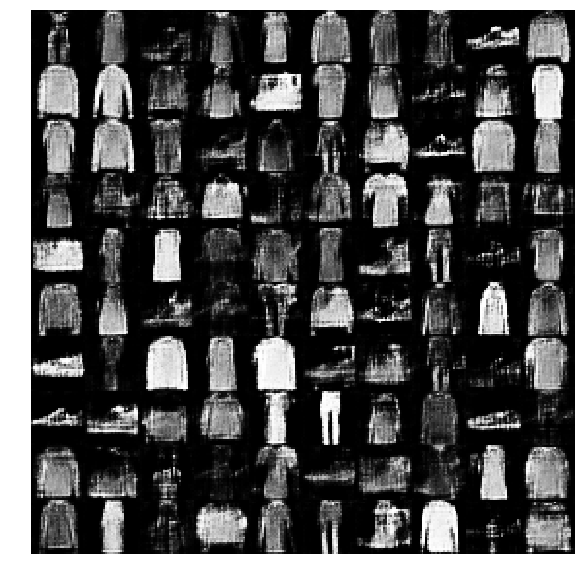

training step 2900: discriminator loss 1.3682538270950317; generator loss 0.774724543094635
training step 3000: discriminator loss 1.2432827949523926; generator loss 0.7580959796905518


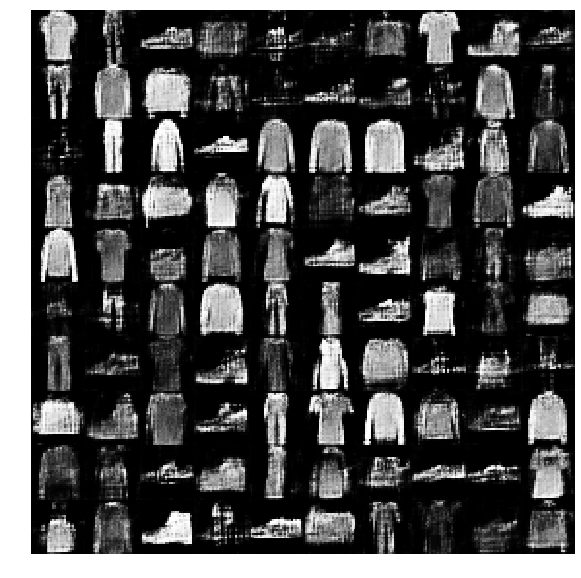

training step 3100: discriminator loss 1.3380581140518188; generator loss 0.7934554815292358
training step 3200: discriminator loss 1.0963666439056396; generator loss 0.4619182348251343


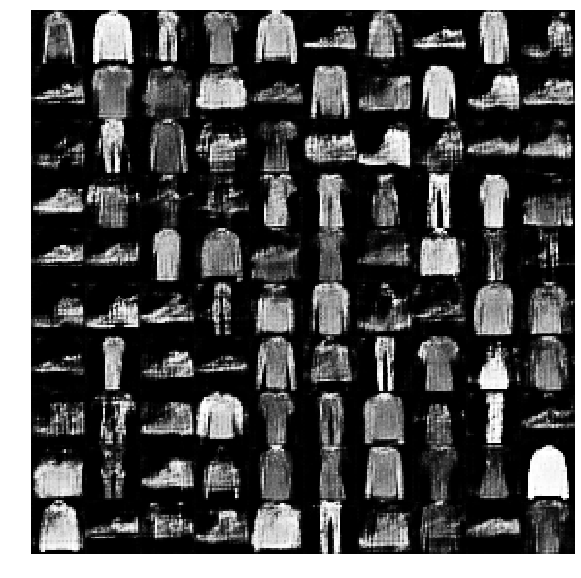

training step 3300: discriminator loss 1.38559889793396; generator loss -0.2306288629770279
training step 3400: discriminator loss 1.2620059251785278; generator loss 0.9086892008781433


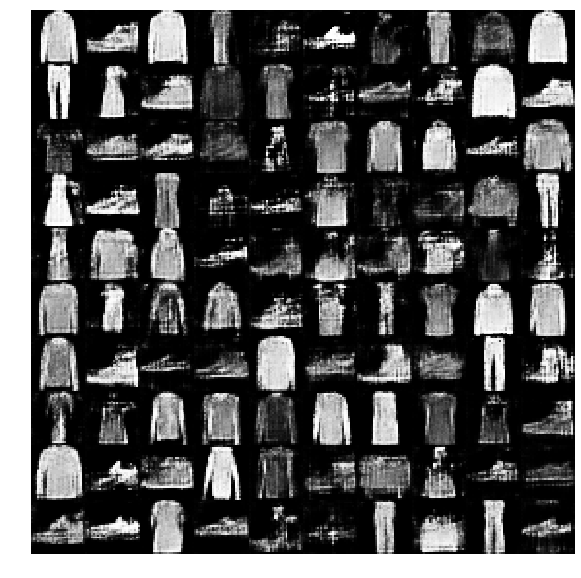

training step 3500: discriminator loss 1.1577571630477905; generator loss 0.7686632871627808
training step 3600: discriminator loss 1.3532471656799316; generator loss 0.9381673336029053


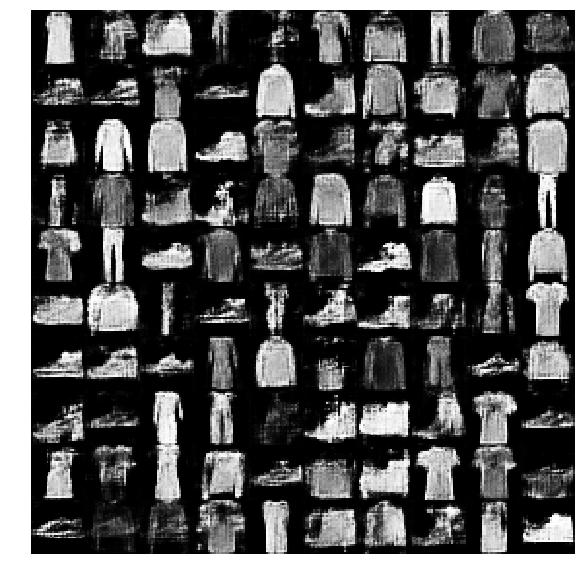

training step 3700: discriminator loss 1.3661980628967285; generator loss -0.15968497097492218
training step 3800: discriminator loss 1.5003204345703125; generator loss 0.9136725664138794


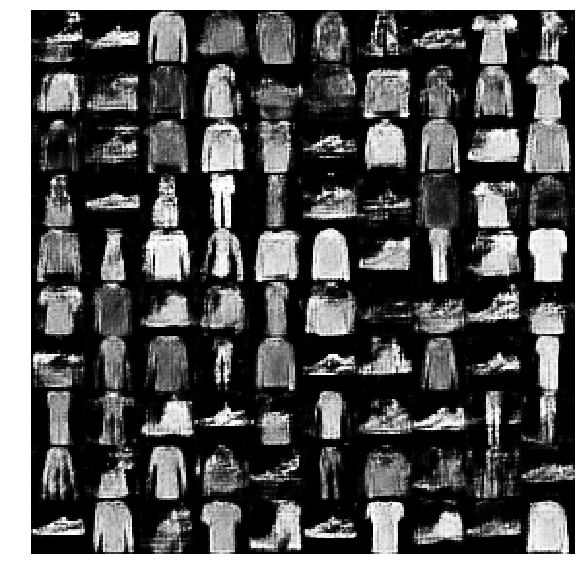

training step 3900: discriminator loss 1.21612548828125; generator loss 0.017238283529877663
training step 4000: discriminator loss 1.1741137504577637; generator loss 0.8591620326042175


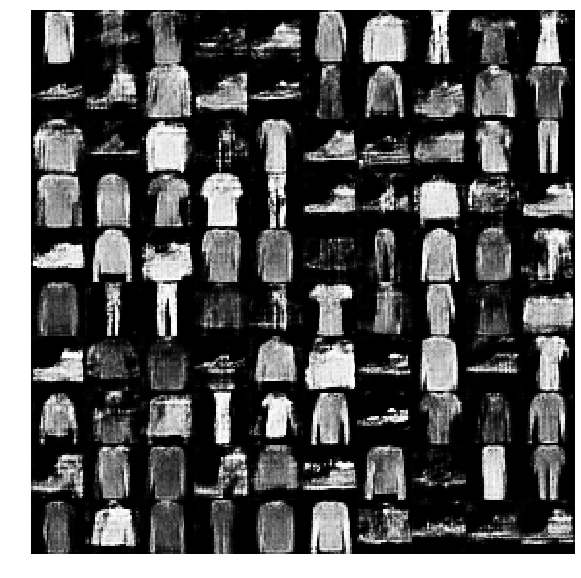

training step 4100: discriminator loss 1.0015053749084473; generator loss 0.7054590582847595
training step 4200: discriminator loss 1.1173837184906006; generator loss 0.8712042570114136


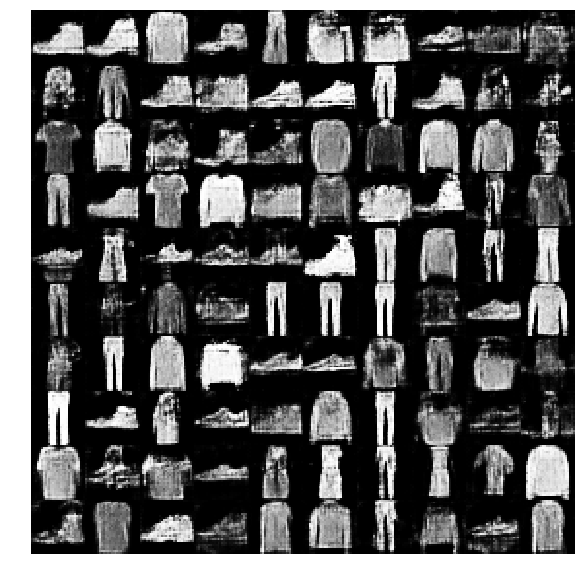

training step 4300: discriminator loss 1.3091399669647217; generator loss -0.08075646311044693
training step 4400: discriminator loss 1.1848680973052979; generator loss 0.3080863952636719


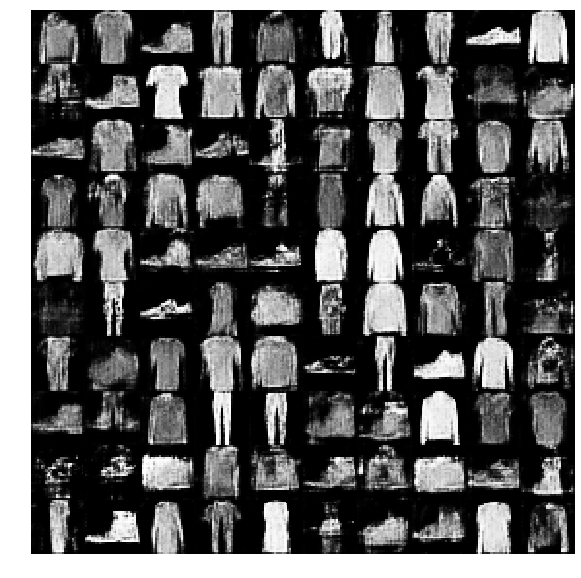

training step 4500: discriminator loss 1.192529559135437; generator loss 0.8696545362472534
training step 4600: discriminator loss 1.0220363140106201; generator loss 0.6642172932624817


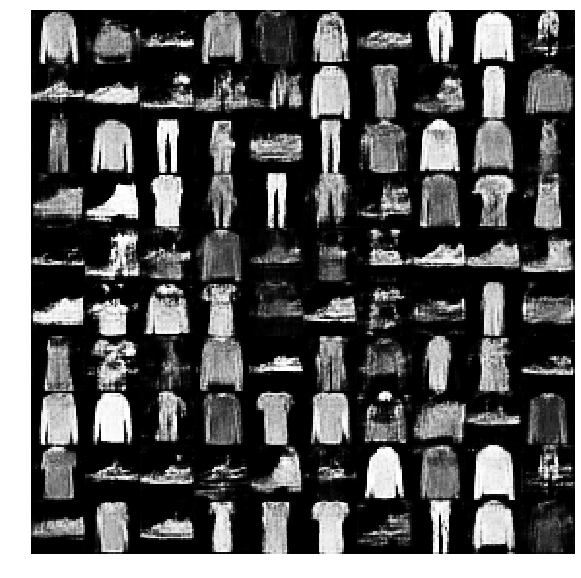

training step 4700: discriminator loss 1.1881979703903198; generator loss 0.05911388248205185
training step 4800: discriminator loss 1.1508586406707764; generator loss 0.6222547292709351


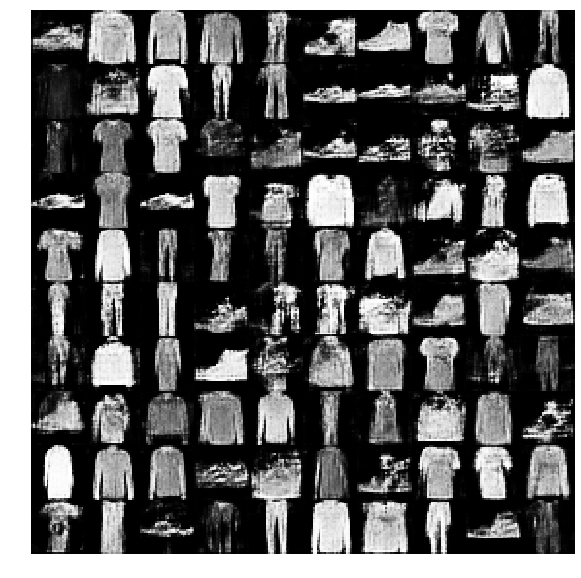

training step 4900: discriminator loss 1.1977214813232422; generator loss 0.11811493337154388
training step 5000: discriminator loss 1.0946900844573975; generator loss 0.28827738761901855


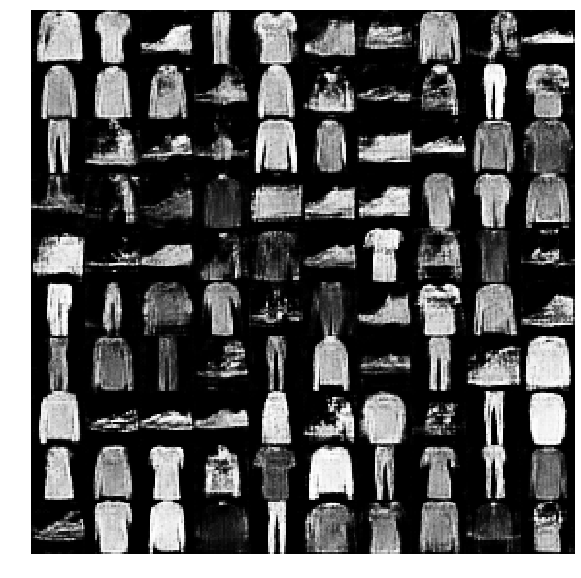

training step 5100: discriminator loss 1.271668791770935; generator loss -0.10739810019731522
training step 5200: discriminator loss 1.1026928424835205; generator loss 0.3390291631221771


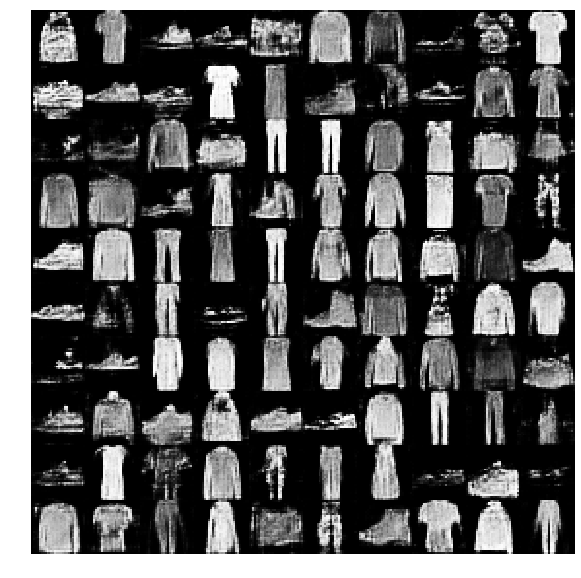

training step 5300: discriminator loss 1.1531269550323486; generator loss 0.7058950662612915
training step 5400: discriminator loss 1.4216715097427368; generator loss -0.30000048875808716


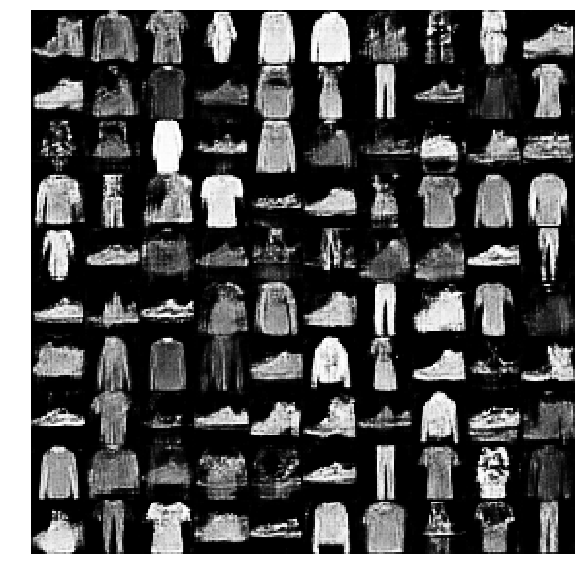

training step 5500: discriminator loss 1.2559113502502441; generator loss 0.09536771476268768
training step 5600: discriminator loss 1.1810787916183472; generator loss 0.808384895324707


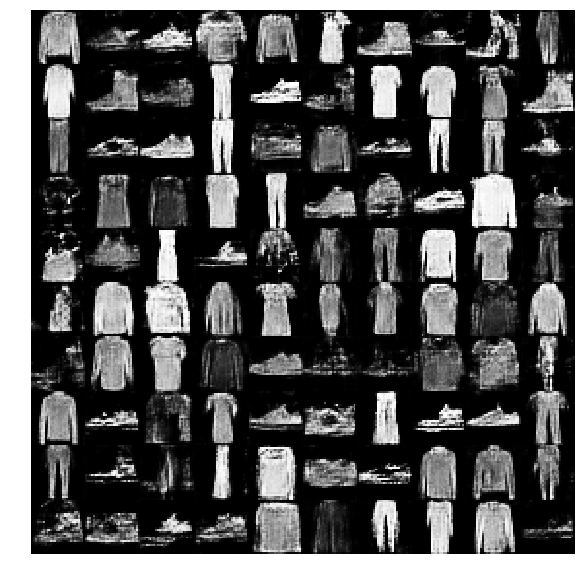

training step 5700: discriminator loss 1.1634398698806763; generator loss 0.017502833157777786
training step 5800: discriminator loss 1.1880543231964111; generator loss 0.69571852684021


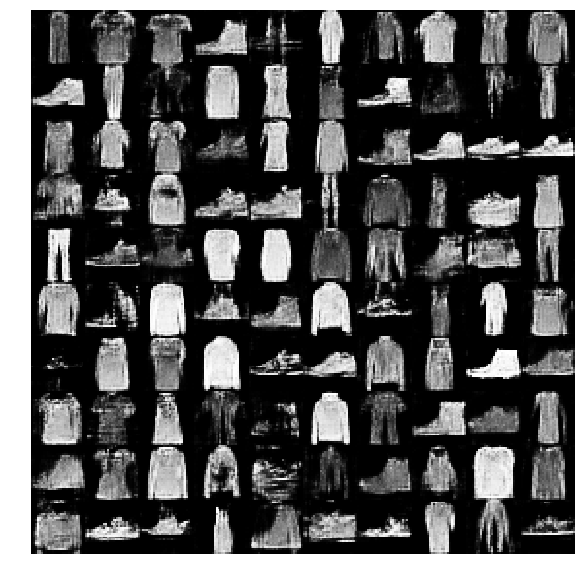

training step 5900: discriminator loss 0.9597651958465576; generator loss 0.8374266028404236
training step 6000: discriminator loss 1.245922565460205; generator loss 0.12339647114276886


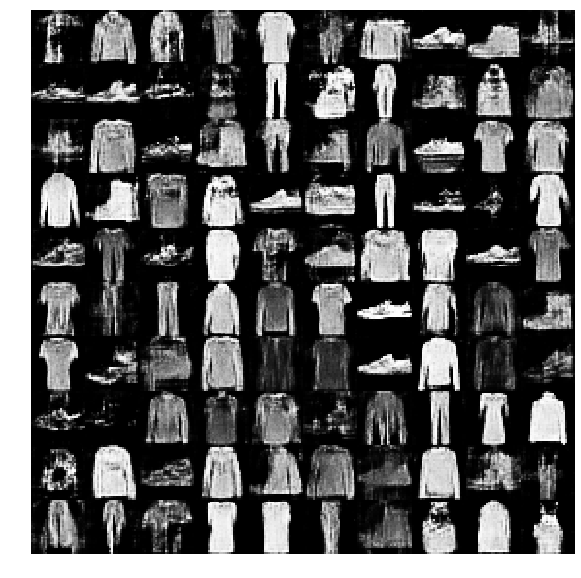

training step 6100: discriminator loss 1.256480097770691; generator loss -0.07500220835208893
training step 6200: discriminator loss 1.1842103004455566; generator loss 0.8716943264007568


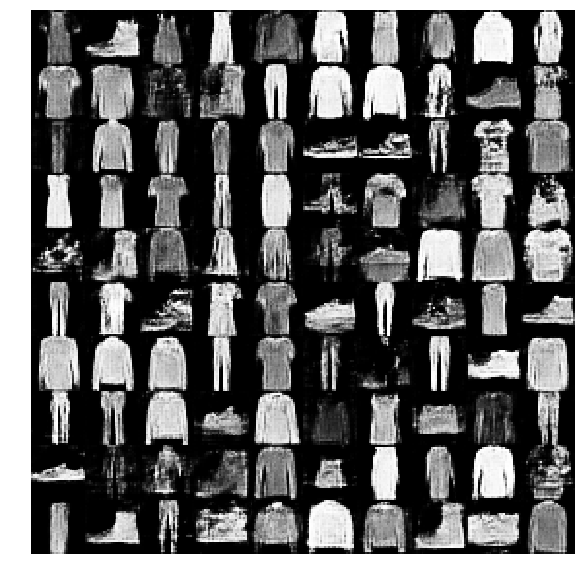

training step 6300: discriminator loss 1.262189269065857; generator loss 0.859347403049469
training step 6400: discriminator loss 1.1653110980987549; generator loss 0.1320064812898636


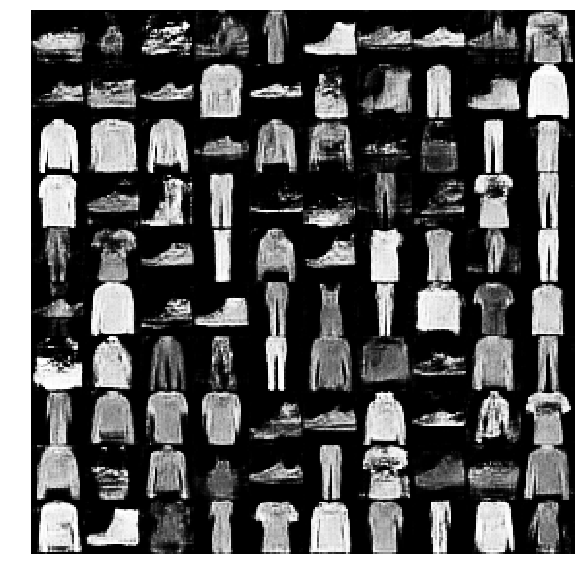

training step 6500: discriminator loss 1.2337664365768433; generator loss 0.010905755683779716
training step 6600: discriminator loss 1.3375880718231201; generator loss 0.8579915761947632


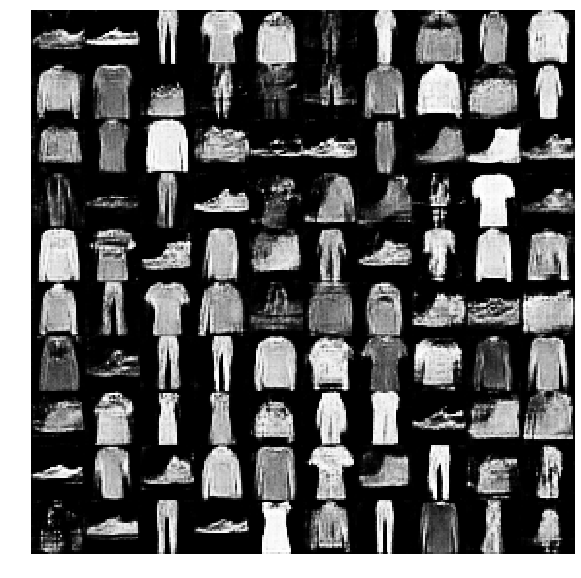

training step 6700: discriminator loss 0.8839816451072693; generator loss 0.526187539100647
training step 6800: discriminator loss 0.8229066133499146; generator loss 0.49858683347702026


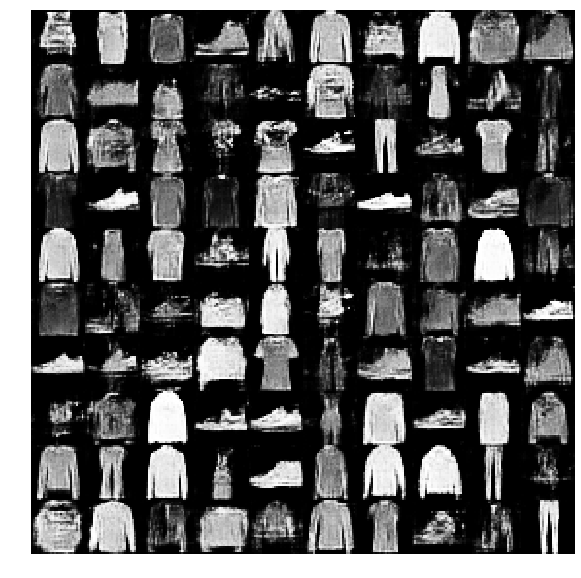

training step 6900: discriminator loss 1.1342073678970337; generator loss 0.8720776438713074
training step 7000: discriminator loss 1.2183759212493896; generator loss 0.05912074074149132


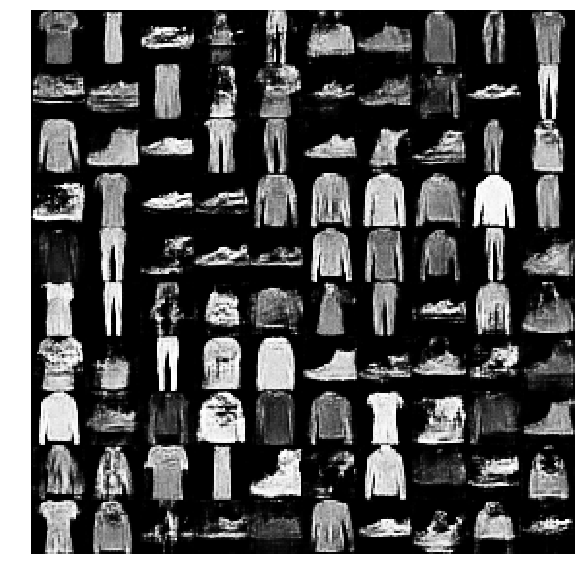

training step 7100: discriminator loss 1.1626062393188477; generator loss 0.17215414345264435
training step 7200: discriminator loss 1.3750414848327637; generator loss -0.22668233513832092


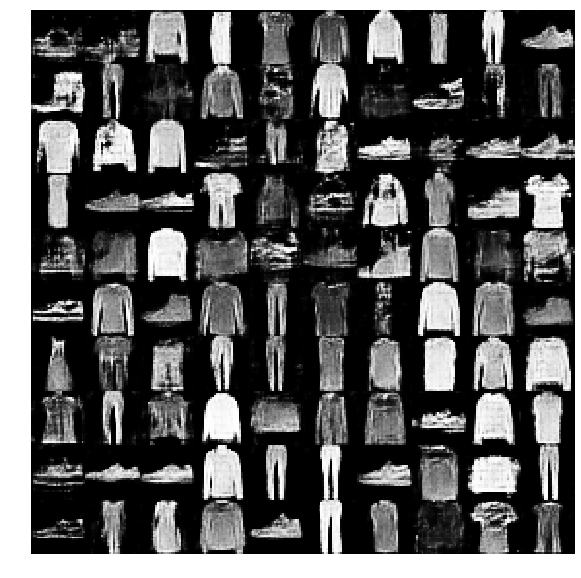

training step 7300: discriminator loss 1.2821483612060547; generator loss 0.919002890586853
training step 7400: discriminator loss 1.0873079299926758; generator loss 0.8037506937980652


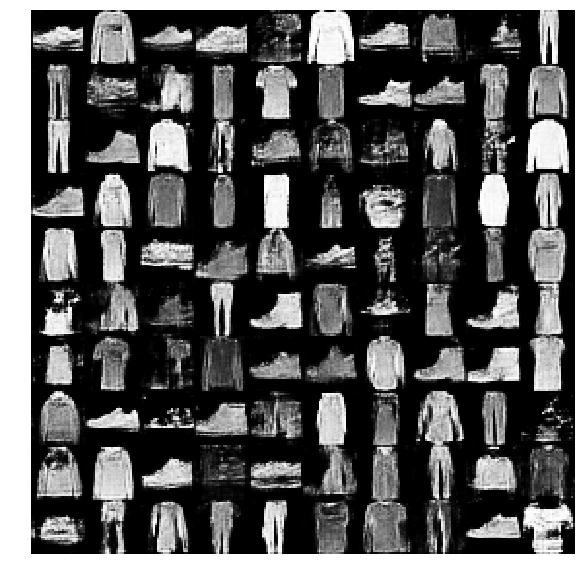

training step 7500: discriminator loss 0.9920936226844788; generator loss 0.5025268793106079
training step 7600: discriminator loss 0.8944860100746155; generator loss 0.5607235431671143


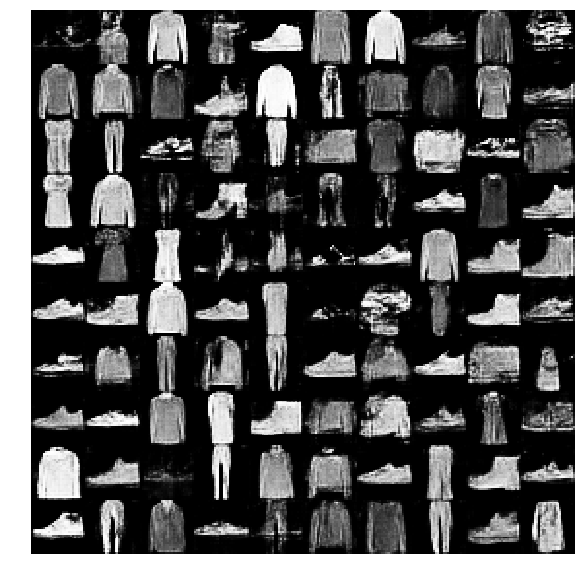

training step 7700: discriminator loss 1.2578129768371582; generator loss 0.07383865118026733
training step 7800: discriminator loss 1.022770881652832; generator loss 0.42033520340919495


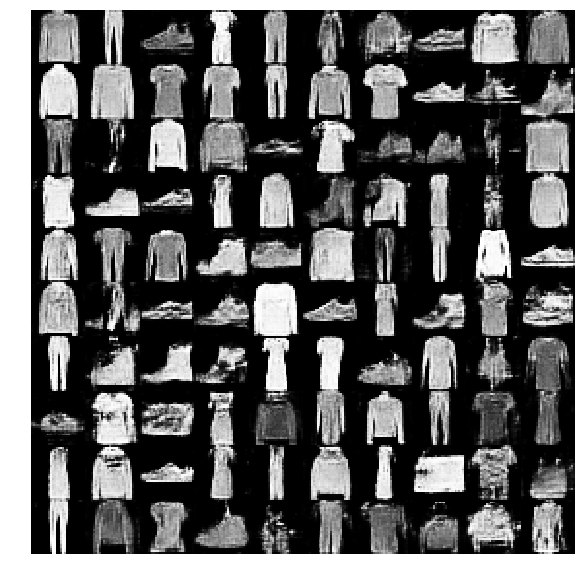

training step 7900: discriminator loss 1.163785457611084; generator loss 0.8428252339363098
training step 8000: discriminator loss 1.2663956880569458; generator loss -0.03184642642736435


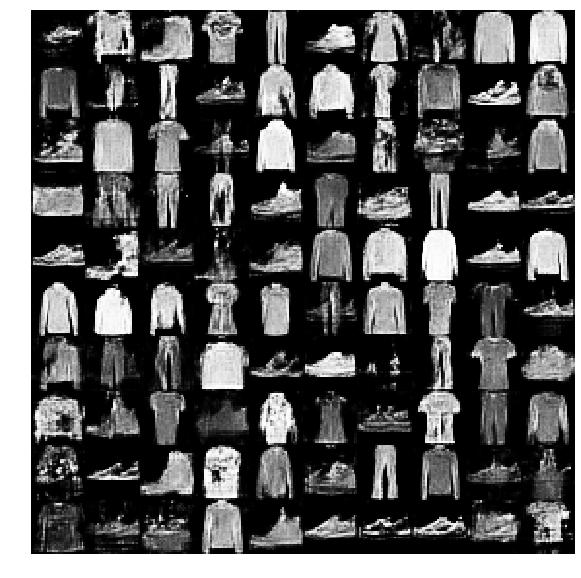

training step 8100: discriminator loss 1.0766915082931519; generator loss 0.14829115569591522
training step 8200: discriminator loss 1.1479076147079468; generator loss 0.7633154392242432


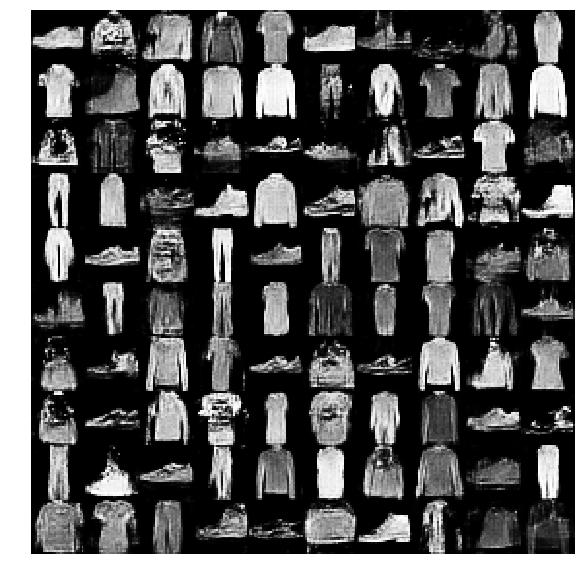

training step 8300: discriminator loss 1.0125479698181152; generator loss 0.7280356287956238
training step 8400: discriminator loss 1.064757227897644; generator loss 0.5696418285369873


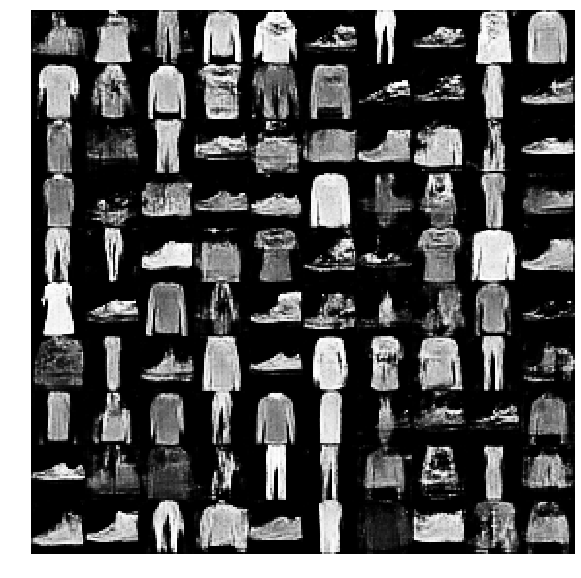

training step 8500: discriminator loss 1.0851048231124878; generator loss 0.7443823218345642
training step 8600: discriminator loss 1.0657331943511963; generator loss 0.7619324922561646


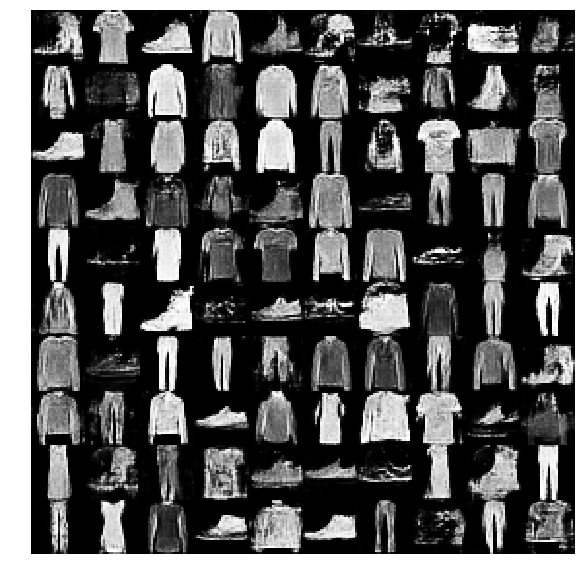

training step 8700: discriminator loss 1.0931452512741089; generator loss 0.7777606844902039
training step 8800: discriminator loss 1.1558758020401; generator loss 0.07092028856277466


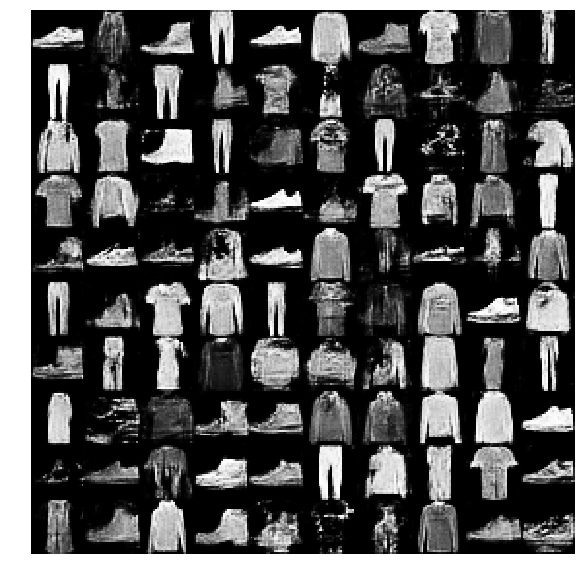

training step 8900: discriminator loss 1.0370458364486694; generator loss 0.740447998046875
training step 9000: discriminator loss 1.2370564937591553; generator loss 0.29781100153923035


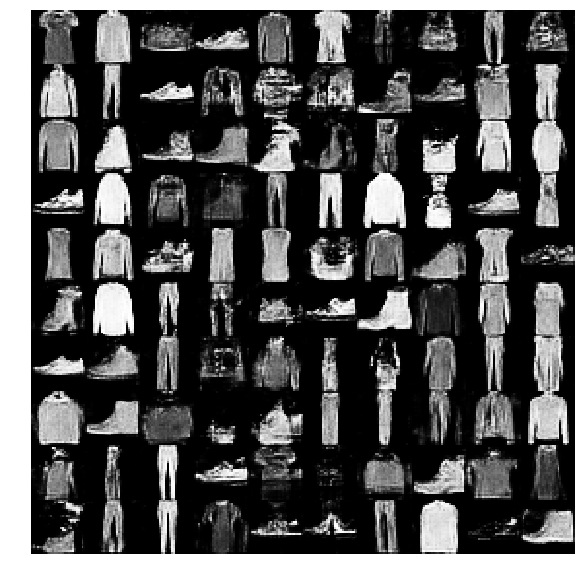

training step 9100: discriminator loss 1.1621981859207153; generator loss 0.8956725597381592
training step 9200: discriminator loss 1.1385252475738525; generator loss 0.09704375267028809


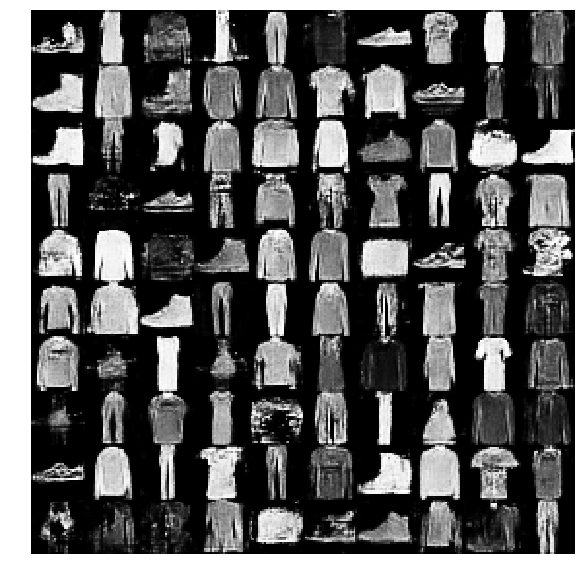

training step 9300: discriminator loss 1.0271638631820679; generator loss 0.8564013838768005
training step 9400: discriminator loss 1.164536714553833; generator loss 0.19638526439666748


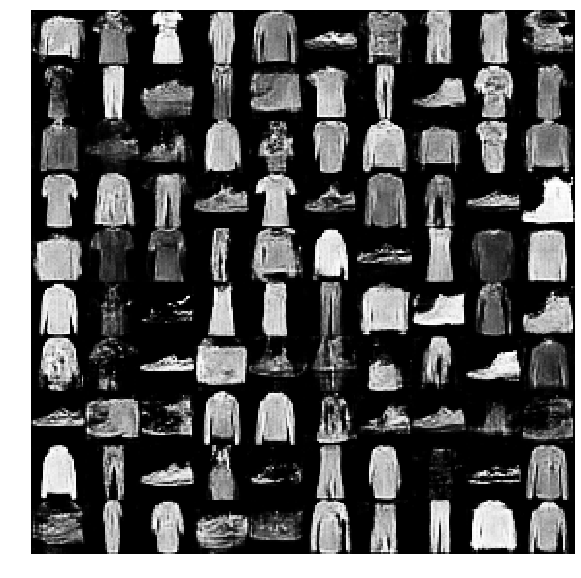

training step 9500: discriminator loss 0.895499587059021; generator loss 0.5227248668670654
training step 9600: discriminator loss 1.1248949766159058; generator loss 0.9188377857208252


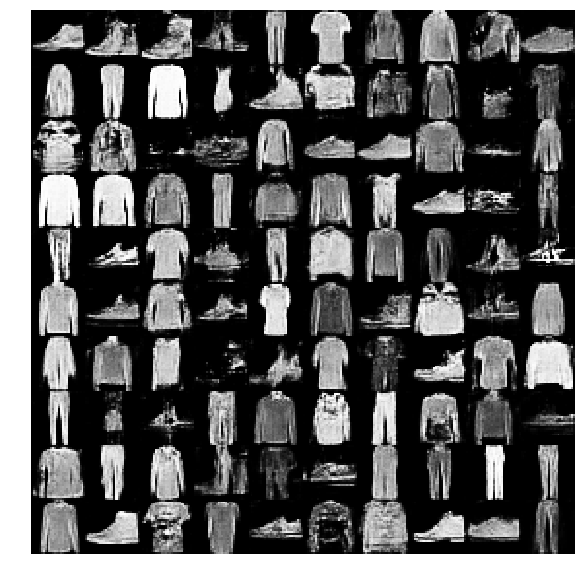

training step 9700: discriminator loss 1.0266597270965576; generator loss 0.7904913425445557
training step 9800: discriminator loss 0.8646364212036133; generator loss 0.48449796438217163


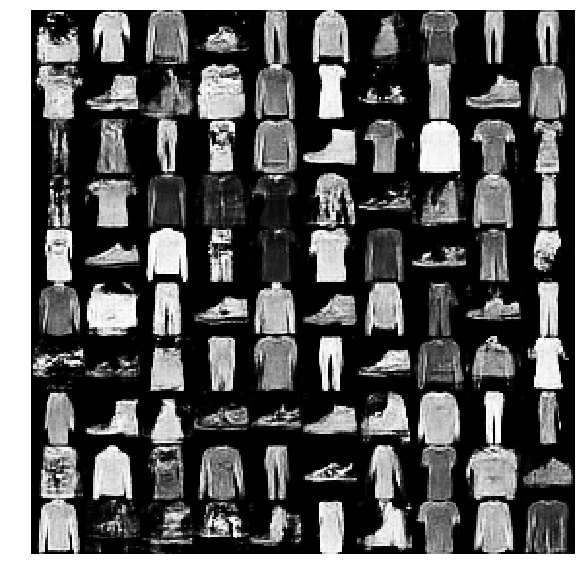

training step 9900: discriminator loss 1.0625706911087036; generator loss 0.8385447859764099
training step 10000: discriminator loss 1.1036527156829834; generator loss 0.08436506986618042


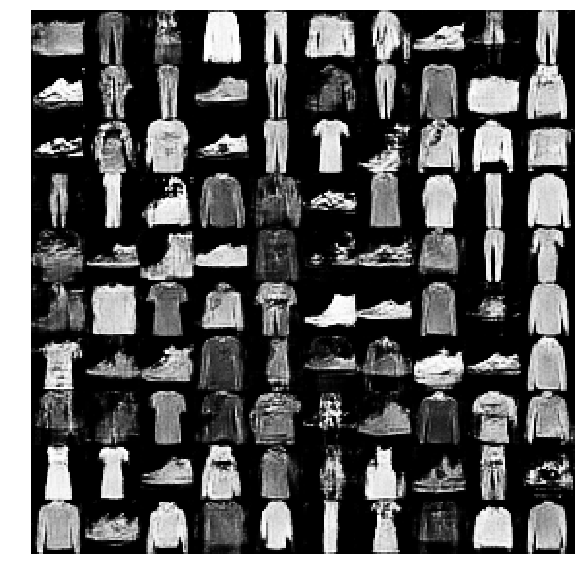

training step 10100: discriminator loss 1.277832269668579; generator loss 0.8833081126213074
training step 10200: discriminator loss 1.0282270908355713; generator loss 0.3151644468307495


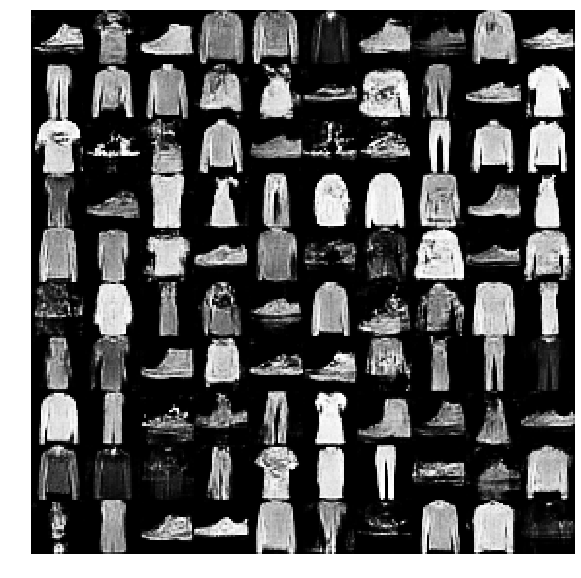

training step 10300: discriminator loss 1.1909828186035156; generator loss 0.8982123136520386
training step 10400: discriminator loss 0.9493488073348999; generator loss 0.7417329549789429


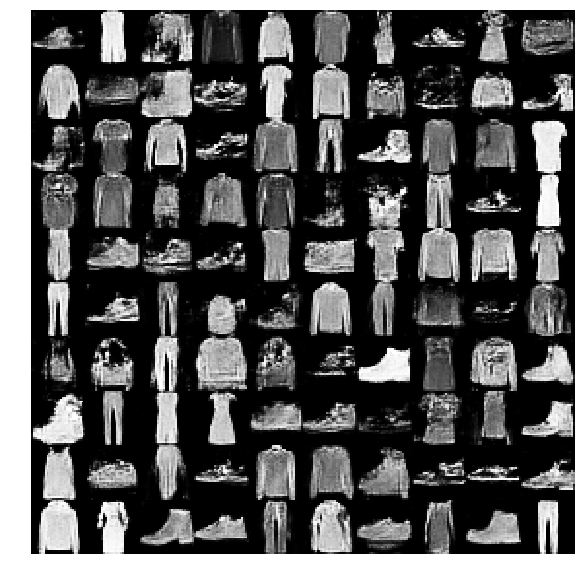

training step 10500: discriminator loss 1.0006994009017944; generator loss 0.3797900080680847
training step 10600: discriminator loss 0.9007102251052856; generator loss 0.5684940814971924


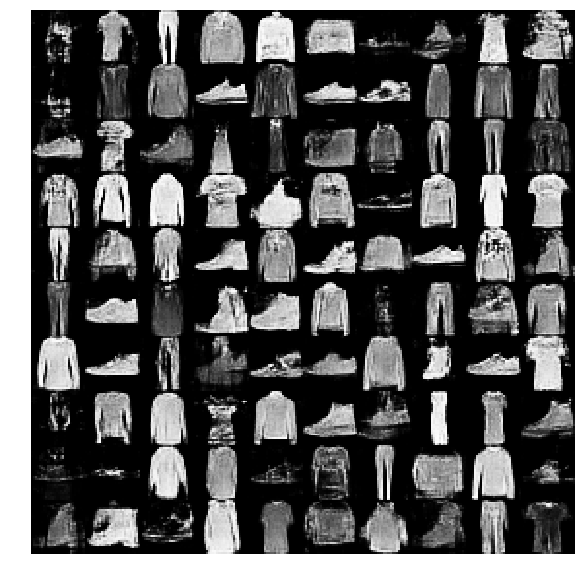

training step 10700: discriminator loss 1.0618906021118164; generator loss 0.7470644116401672
training step 10800: discriminator loss 1.1073219776153564; generator loss 0.9116523265838623


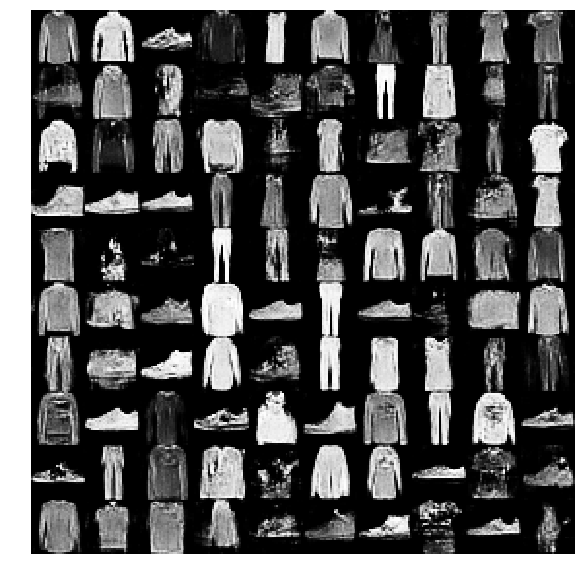

training step 10900: discriminator loss 1.070469617843628; generator loss 0.20992036163806915


In [36]:
# create global training step tracker object
global_step = tf.train.get_or_create_global_step()

# keep track of losses
d_losses, g_losses = [], []


for real_img_batch in dataset:

    # construct random normal z input to feed into generator
    input_z = tf.random_normal(shape=(BATCH_SIZE, LATENT_DIM), dtype='float32')

    # define gradient tapes to start recording computation operations
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape: # Gradient Tape: Create these tapes as content wrappers
                                                                   # Keep track of all the computation done in that context
                                                                   # Automatically apply differentiation using Autograd
        # <TODO>
        # FORWARD RUN TO COMPUTE G/D-NET LOSSES
        # ----------------------------------------------------------------------
        # 1. run g_net with input_z to generate batch of fake images
        g_fake_images = g_net(input_z, training=True)
        # 2. run d_net with the batch of generated fake images
        d_logits_fake = d_net(g_fake_images, training=True)
        # 3. run d_net with a batch of real images from dataset
        d_logits_real = d_net(real_img_batch, training=True)
        # 4. compute g_net losses with feedback from the d_net
        g_loss = compute_g_loss(d_logits_fake)
        g_losses.append(g_loss)
        
        # 5. compute d_net losses by revealing its logit values for both
        #    real and fake images
        d_loss =  compute_d_loss(d_logits_real, d_logits_fake)
        d_losses.append(d_loss)
        
                          
        # UPDATE G/D-NET PARAMETERS
        # ----------------------------------------------------------------------
        # 1. get all learn-able G/D-net parameters (i.e. parameters to optimize)
        d_variables = d_net.variables
        g_variables = g_net.variables
                
        # 2. compute d(d_loss)/dx, d(g_loss)/dx
        d_grads = d_tape.gradient(d_loss, d_variables)
        g_grads = g_tape.gradient(g_loss, g_variables)

        # 3. apply gradient updates to the parameters
        d_optimizer.apply_gradients(zip(d_grads, d_variables),
                                    global_step=global_step)
        g_optimizer.apply_gradients(zip(g_grads, g_variables),
                                    global_step=global_step)

    
    # EVERY NOW & THEN, DISPLAY OUTPUT TO TRACK TRAINING PROGRESS
    # ----------------------------------------------------------------------
    # get training step
    step = global_step.numpy()
    
    # display losses every 100 steps
    if step % 100==0:
        print('training step {}: discriminator loss {}; generator loss {}'\
              .format(step, d_loss, g_loss))
    
    
    # display sample images every SAMPLE_PER_N_STEPS
    if step % SAMPLE_PER_N_STEPS==0:      
        
        # 1. create a batch of (100, LATENT_DIM) z-input tensor
        eval_z = tf.random_normal(shape=(100, LATENT_DIM), dtype='float32')

        # 2. generate images by using G-net
        eval_img = g_net(eval_z, training=False)
        
        # 3. organize the images into a grid
        img_grid = tf.contrib.gan.eval.image_grid(
                        input_tensor=eval_img,
                        grid_shape=(10,10),
                        image_shape=(H, W),
                        num_channels=C
                    )
                
        # 4. plot the image grid
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid[0,:,:,0], cmap='gray')
        plt.axis('off')
        plt.show()